# **Pose Graph Optimization (using g2o)**

[g2o - General Graph Optimization (C++ framework)](https://github.com/RainerKuemmerle/g2o) \\
[Python binding of g2o](https://github.com/uoip/g2opy)

Installing some necessary libraries and dependencies for the working of g2o library.
[Requirements](https://github.com/RainerKuemmerle/g2o/blob/master/README.md#requirements)

In [1]:
!apt-get install libeigen3-dev libsuitesparse-dev qtdeclarative5-dev qt5-qmake libqglviewer-dev-qt4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
qt5-qmake is already the newest version (5.9.5+dfsg-0ubuntu2.5).
qt5-qmake set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libamd2 libaudio2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcxsparse3 libgl1-mesa-glx libgraphblas1 libklu1 libldl2 libmetis5 libmng2
  libqglviewer-headers libqglviewer2-qt4 libqt4-dbus libqt4-declarative
  libqt4-designer libqt4-dev libqt4-dev-bin libqt4-help libqt4-network
  libqt4-opengl libqt4-opengl-dev libqt4-qt3support libqt4-script
  libqt4-scripttools libqt4-sql libqt4-sql-mysql libqt4-svg libqt4-test
  libqt4-xml libqt4-xmlpatterns libqt5qml5 libqt5quick5 libqt5quickparticles5
  libqt5quicktest5 libqt5quickwidgets5 libqtcore4 libqtdbus4 libqtgui4
  librbio2 libspqr2 libsuitespars

Cloning the repository and building it.

In [2]:
!git clone https://github.com/uoip/g2opy.git

Cloning into 'g2opy'...
remote: Enumerating objects: 1099, done.
remote: Total 1099 (delta 0), reused 0 (delta 0), pack-reused 1099
Receiving objects: 100% (1099/1099), 3.72 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (301/301), done.


In [3]:
%cd g2opy
!mkdir build
%cd build
!cmake ..
!make -j8
%cd ..
!python setup.py install

/content/g2opy
/content/g2opy/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Compiling on Unix
-- Found CHOLMOD: /usr/include/suitesparse  
-- Looking for sgemm_
-- Looking for sgemm_ - found
-- A library with BLAS API found.
-- Looking for cheev_
-- Looking for cheev_ - found
-- A library with LAPACK API found.
-- Found CHOLMOD and its dependencies
-- Found CSPARSE: /usr/include/suitesparse  
-- Building LGPL code as static library (affect

In [4]:
import g2o

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import os

Generating a sample trajectory on a 2D plane for 2D Pose Graph Optimization. The optimized output trajectory should be close to this Ground Truth trajectory.

In [7]:
def genTraj():
    init = (0, 0)

    # Forward I
    num = 20; xSt = -5; ySt = -8; leng = 10.0; step = float(leng)/num
    X1 = np.zeros(num); Y1 = np.zeros(num); X1[0] = xSt; Y1[0] = ySt
    for i in range(1, num):
        X1[i] = X1[i-1] + step
        Y1[i] = ySt

    # UTurn I
    rad = 2.5; num = 20
    xCen = X1[-1]; yCen = Y1[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X2 = np.zeros(num); Y2 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X2[i] = (xCen + rad*math.cos(theta))
        Y2[i] = (yCen + rad*math.sin(theta))

    # Backward I
    num = 20; leng = 10.0; step = float(leng)/num
    xSt = X2[-1]; ySt = Y2[-1]
    X3 = np.zeros(num); Y3 = np.zeros(num); X3[0] = xSt; Y3[0] = ySt 
    for i in range(1, num):
        X3[i] = X3[i-1] - step
        Y3[i] = ySt

    # UTurn II
    rad = 2.5; num = 20
    xCen = X3[-1]; yCen = Y3[-1] - rad
    thetas = np.linspace(math.pi/2, 3*math.pi/2, num)
    X4 = np.zeros(num); Y4 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X4[i] = (xCen + rad*math.cos(theta))
        Y4[i] = (yCen + rad*math.sin(theta))

    # Forward II
    num = 20; leng = 10.0; step = float(leng)/num
    xSt = X4[-1]; ySt = Y4[-1]
    X5 = np.zeros(num); Y5 = np.zeros(num); X5[0] = xSt; Y5[0] = ySt
    for i in range(1, num):
        X5[i] = X5[i-1] + step
        Y5[i] = ySt

    # UTurn III
    rad = 2.5; num = 20
    xCen = X5[-1]; yCen = Y5[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X6 = np.zeros(num); Y6 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X6[i] = (xCen + rad*math.cos(theta))
        Y6[i] = (yCen + rad*math.sin(theta))	

    # Assemble
    X = np.concatenate([X1, X2, X3, X4, X5, X6]); Y = np.concatenate([Y1, Y2, Y3, Y4, Y5, Y6])
    THETA = np.array(getTheta(X, Y))

    return (X, Y, THETA)


def getTheta(X ,Y):
    THETA = [None]*len(X)
    for i in range(1, len(X)-1):
        if(X[i+1] == X[i-1]):
            if (Y[i+1]>Y[i-1]):
                THETA[i] = math.pi/2
            else:
                THETA[i] = 3*math.pi/2
            continue

        THETA[i] = math.atan((Y[i+1]-Y[i-1])/(X[i+1]-X[i-1]))

        if(X[i+1]-X[i-1] < 0):
            THETA[i] += math.pi 

    if X[1]==X[0]:
        if Y[1] > Y[0]:
            THETA[0] = math.pi/2
        else:
            THETA[0] = 3*math.pi/2
    else:
        THETA[0] = math.atan((Y[1]-Y[0])/(X[1]-X[0]))

    if X[-1] == X[len(Y)-2]:
        if Y[1] > Y[0]:
            THETA[-1] = math.pi/2
        else:
            THETA[-1] = 3*math.pi/2
    else:
        THETA[-1] = math.atan((Y[-1]-Y[len(Y)-2])/(X[-1]-X[len(Y)-2]))

    return THETA

In [8]:
(X, Y, THETA) = genTraj()

In [9]:
# Some functions to plot the trajectories using matplotlib

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'k-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'm->')

    plt.show()


def drawTwo(X1, Y1, THETA1, X2, Y2, THETA2):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    plt.legend()
    plt.show()


def drawThree(X1, Y1, THETA1, X2, Y2, THETA2, X3, Y3, THETA3):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    ax.plot(X3, Y3, 'go', label='Noisy')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'g->')

    plt.legend()
    plt.show()

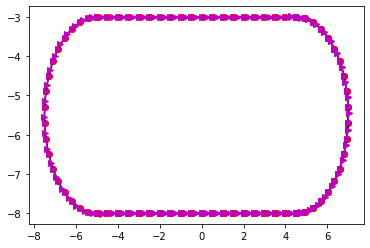

In [10]:
draw(X, Y, THETA)

The above plot represents the Ground Truth trajectory but the measurements obtained from odometry estimation will not be exactly this due to the presence of sensor noise which results in drift in the pose estimation over time.

In [11]:
# Adding noise to the Ground Truth trajectory

def addNoise(X, Y, THETA):
    xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
    xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

    for i in range(1, len(X)):
        # Get T2_1
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        # Add noise
        if(i<5):
            xNoise = 0; yNoise = 0; tNoise = 0
        else:
            xNoise = np.random.normal(0, 0.03); yNoise = np.random.normal(0, 0.03); tNoise = np.random.normal(0, 0.03)
        del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise

        # Convert to T2_1'
        T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])

        # Get T2_w' = T1_w' . T2_1'
        p1 = (xN[i-1], yN[i-1], tN[i-1])
        T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_wN = np.dot(T1_wN, T2_1N)

        # Get x2', y2', theta2'
        x2N = T2_wN[0][2]
        y2N = T2_wN[1][2]
        theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])

        xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N  

    # tN = getTheta(xN, yN)

    return (xN, yN, tN)

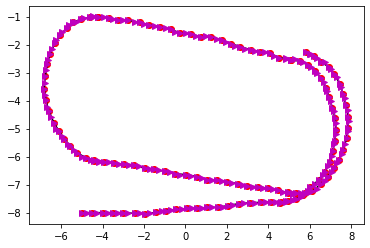

In [12]:
(xN, yN, tN) = addNoise(X, Y, THETA)
draw(xN, yN, tN)

The above plot is more likely going to be the obtained odometry estimate which has to be optimized using Pose Graph Optimization.

In [17]:
def writeOdom(X, Y, THETA):
    g2o = open('noise.g2o', 'w')

    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        line = "VERTEX_SE2 " + str(i) + " " + str(x) + " " + str(y) + " " + str(theta)
        # print(line)
        g2o.write(line)
        g2o.write("\n")

    info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"
    for i in range(1, len(X)):
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(i-1)+" "+str(i)+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        g2o.write(line)
        g2o.write("\n")

    g2o.write("FIX 0")
    g2o.write("\n")
    # g2o.close()
    return g2o


def writeLoop(X, Y, THETA, g2o):
    # sz = X.size

    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))
    # for i in range(len(X)):
    # 	pairs.append((0, i))

    info_mat = "700.0 0.0 0.0 700.0 0.0 700.0"

    for p in pairs:
        # print(p)
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        # print(T2_1)
        # print(p1)
        # print(p2)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(p[0])+" "+str(p[1])+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        # print(line)
        g2o.write(line)
        g2o.write("\n")

    g2o.close()

In [18]:
g2o = writeOdom(xN, yN, tN)
writeLoop(X, Y, THETA, g2o)

The below cell takes a .g2o which consists of noisy poses and directly optimizes it to produce the output. For a more detailed approach of building a graph and then optimizing it read further.

In [19]:
import numpy as np
import g2o 
import os

def main():
    #solver = g2o.BlockSolverX(g2o.LinearSolverCholmodX())
    solver = g2o.BlockSolverSE2(g2o.LinearSolverEigenSE2())
    solver = g2o.OptimizationAlgorithmLevenberg(solver)

    optimizer = g2o.SparseOptimizer()
    optimizer.set_verbose(True)
    optimizer.set_algorithm(solver)

    optimizer.load('noise.g2o')
    print('num vertices:', len(optimizer.vertices()))
    print('num edges:', len(optimizer.edges()), end='\n\n')

    optimizer.initialize_optimization()
    optimizer.optimize(20)

    if len('opt.g2o') > 0:
        optimizer.save('opt.g2o')


if __name__ == '__main__':        
    main()
    print("done")

num vertices: 120
num edges: 139

done


In [21]:
def readG2o(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    X = []
    Y = []
    THETA = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split(' ')
            X.append(float(x))
            Y.append(float(y))
            THETA.append(float(theta.rstrip('\n')))

    return (X, Y, THETA)

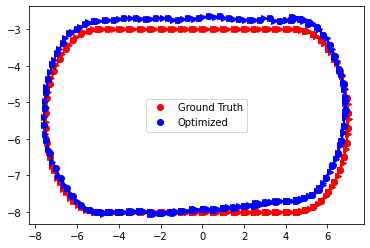

In [22]:
(xOpt, yOpt, tOpt) = readG2o("opt.g2o")
drawTwo(X, Y, THETA, xOpt, yOpt, tOpt)

The below plot shows all the three trajectories : Ground Truth, Noisy and the Optimized trajectories.

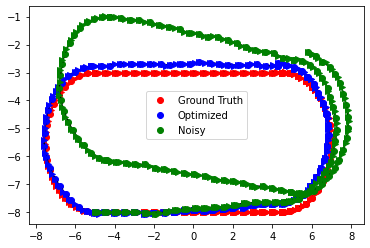

In [23]:
drawThree(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)

Defining the class for PoseGraphOptimization. This will help in building up the graph by adding vertices (nodes) which need to be optimized and the edges which are measurements or constraints.

In [28]:
import numpy
import g2o

class PoseGraphOptimization(g2o.SparseOptimizer):
    def __init__(self):
        super().__init__()
        solver = g2o.BlockSolverSE2(g2o.LinearSolverEigenSE2())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)

    def optimize(self, max_iterations=20):
        print('num vertices:', len(super().vertices()))
        print('num edges:', len(super().edges()), end='\n\n')
        super().initialize_optimization()
        super().optimize(max_iterations)
        super().set_verbose(True)
        print("done")
        if len('opt2.g2o') > 0:
            super().save('opt2.g2o')

    def add_vertex(self, id, pose, fixed=False):
        v_se2 = g2o.VertexSE2()
        v_se2.set_id(id)
        v_se2.set_estimate(pose)
        v_se2.set_fixed(fixed)
        super().add_vertex(v_se2)

    def add_edge(self, vertices, measurement, 
            information=np.identity(3),
            robust_kernel=None):

        edge = g2o.EdgeSE2()
        for i, v in enumerate(vertices):
            if isinstance(v, int):
                v = self.vertex(v)
            # print(v.id())
            edge.set_vertex(i, v)
        # print(measurement.rotation().R)
        # print(measurement.translation())
        # print((edge.vertex(0).estimate().inverse() * 
        #         edge.vertex(1).estimate()).translation())
        edge.set_measurement(measurement)  # relative pose
        edge.set_information(information)
        if robust_kernel is not None:
            edge.set_robust_kernel(robust_kernel)
        super().add_edge(edge)

    def get_pose(self, id):
        return self.vertex(id).estimate()

In [29]:
graph = PoseGraphOptimization()

In [30]:
def writeOdom(X, Y, THETA):
    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        pose = g2o.SE2(x,y,theta)
        if (i==0):
          graph.add_vertex(i, pose, True)
        else:
          graph.add_vertex(i, pose)

    info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"
    for i in range(1, len(X)):
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        # del_x = float(T2_1[0][2])
        # del_y = float(T2_1[1][2])
        # del_theta = float(math.atan2(T2_1[1, 0], T2_1[0, 0]))
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])
        meas = g2o.SE2(del_x,del_y,del_theta)
        # meas = T2_1
        graph.add_edge((i-1, i), meas, 500.0*np.eye(3))
    
    sz = X.size

    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))

    info_mat = "700.0 0.0 0.0 700.0 0.0 700.0"
    for p in pairs:
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        # print(T2_1)
        # print(p1)
        # print(p2)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])
        meas = g2o.SE2(0,0,0)
        # meas = T2_1
        # line = "EDGE_SE2 "+str(p[0])+" "+str(p[1])+" "+str(del_x)+" "+str(del_y)+" "+str(del_theta)+" "+str(info_mat)
        # print(line)
        graph.add_edge((p[0], p[1]), meas, 700.0*np.eye(3))

In [31]:
writeOdom(xN, yN, tN)

In [32]:
graph.optimize(100)

num vertices: 120
num edges: 139

done


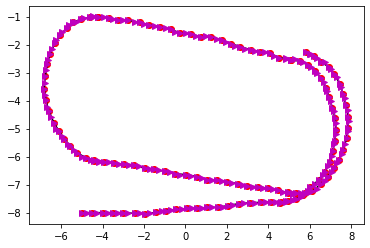

In [33]:
draw(xN, yN, tN)

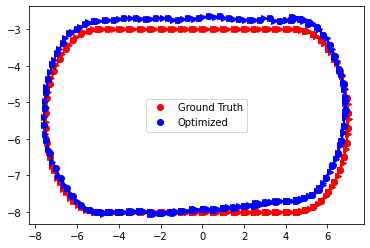

In [34]:
(xOpt, yOpt, tOpt) = readG2o("opt2.g2o")
drawTwo(X, Y, THETA, xOpt, yOpt, tOpt)

Again plotting all the three trajectories : Ground Truth, Noisy and the Optimized trajectories.

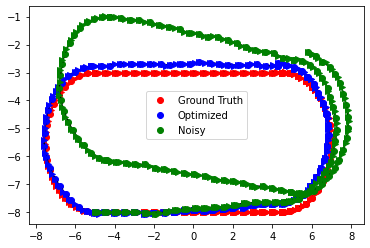

In [35]:
drawThree(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)